# Task 4: Optimize Portfolio Based on Forecast

1. **Import Necessary Libraries**

- First, set up your libraries.

In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Step 1: Load Forecasted Data

**Assuming df contains forecasted daily closing prices for TSLA, BND, SPY**

In [3]:
data = pd.read_csv('../data/cleaned_Tsla.csv', parse_dates=['Date'], index_col='Date')
data1 = pd.read_csv('../data/cleaned_bnd.csv', parse_dates=['Date'], index_col='Date')
data2 = pd.read_csv('../data/cleaned_spy.csv', parse_dates=['Date'], index_col='Date')

In [5]:
forecast_period = 180  # Number of days for the forecast
data = data.tail(forecast_period)
data1 = data1.tail(forecast_period)
data2 = data2.tail(forecast_period)


### Step 2: Merge the datasets
 Merge on the Date index, aligning the data

In [12]:
df = pd.concat([data['Close'], data1['Close'], data2['Close']], axis=1, keys=['TSLA', 'BND', 'SPY'])

In [13]:
# Drop rows with missing data (if any)
df = df.dropna()

### Step 3: Calculate Daily Returns and Annualized Return/Volatility

In [14]:
daily_returns = df.pct_change().dropna()  # Calculate daily returns and remove NaN rows
annual_returns = daily_returns.mean() * 252  # Annualized returns (assuming 252 trading days)
cov_matrix = daily_returns.cov() * 252  # Annualized covariance matrix

### Step 4: Portfolio Optimization
Define the initial guess and bounds for each asset's weight

In [15]:
num_assets = len(df.columns)
weights = np.ones(num_assets) / num_assets  # Initial equally weighted
bounds = [(0, 1) for _ in range(num_assets)]  # Each weight is between 0 and 1
constraints = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}  # Sum of weights = 1


In [16]:
# Define portfolio metrics
def portfolio_performance(weights, returns, cov_matrix):
    portfolio_return = np.dot(weights, returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = portfolio_return / portfolio_volatility
    return portfolio_return, portfolio_volatility, sharpe_ratio

In [17]:
# Objective function to maximize Sharpe Ratio
def neg_sharpe_ratio(weights, returns, cov_matrix):
    return -portfolio_performance(weights, returns, cov_matrix)[2]

In [18]:
# Optimize weights to maximize Sharpe Ratio
optimized_result = minimize(neg_sharpe_ratio, weights, args=(annual_returns, cov_matrix), 
                            method='SLSQP', bounds=bounds, constraints=constraints)
optimal_weights = optimized_result.x

### Step 5: Calculate Optimized Portfolio Metrics

the goal is to calculate and interpret the key metrics of the optimized portfolio based on the weights derived from the optimization process. Here’s a breakdown of the key elements involved:

## Key Metrics Calculated:
**Optimized Portfolio Return (opt_return):**

- This represents the expected annual return of the optimized portfolio.

- It is computed by multiplying the asset weights (from the optimization) with their respective annual returns, and then summing the results.

- Formula: 
            
            Portfolio Return= ∑wi⋅ri
​
Where:
- w i   is the weight of asset i in the portfolio.
- 𝑟𝑖  is the expected annual return of asset 𝑖.
- 𝑁 is the total number of assets in the portfolio.

**Optimized Portfolio Volatility (opt_volatility):**

- This measures the risk or volatility of the optimized portfolio.

- It’s calculated as the standard deviation of the portfolio returns, considering the correlation and variances of the assets in the portfolio.

**Sharpe Ratio (opt_sharpe):**

- The Sharpe Ratio is a measure of the risk-adjusted return of the portfolio.

- It is calculated by dividing the expected portfolio return by the portfolio’s volatility (risk). The higher the Sharpe ratio, the better the portfolio’s return per unit of risk.

- This metric helps investors understand whether they are being compensated for taking on additional risk. A higher Sharpe ratio indicates a more efficient portfolio.


**Purpose of optimized metrics:**

**Objective:** 
- The purpose of this step is to summarize the performance of the portfolio after the optimization process. The optimized portfolio is designed to achieve the best possible return for the level of risk an investor is willing to accept (maximizing the Sharpe ratio).
 - By calculating these metrics, you can evaluate the **effectiveness of the portfolio optimization** and assess whether the portfolio provides a good balance between return and risk.

In [19]:
opt_return, opt_volatility, opt_sharpe = portfolio_performance(optimal_weights, annual_returns, cov_matrix)

### Step 6: Value at Risk (VaR) for TSLA at 95% Confidence Interval

In [20]:
confidence_level = 0.95
mean_tsla = daily_returns['TSLA'].mean()
std_tsla = daily_returns['TSLA'].std()
VaR_tsla = mean_tsla + std_tsla * np.percentile(daily_returns['TSLA'], (1-confidence_level) * 100)

### Step 7: Visualization
Plot Portfolio Performance over Time

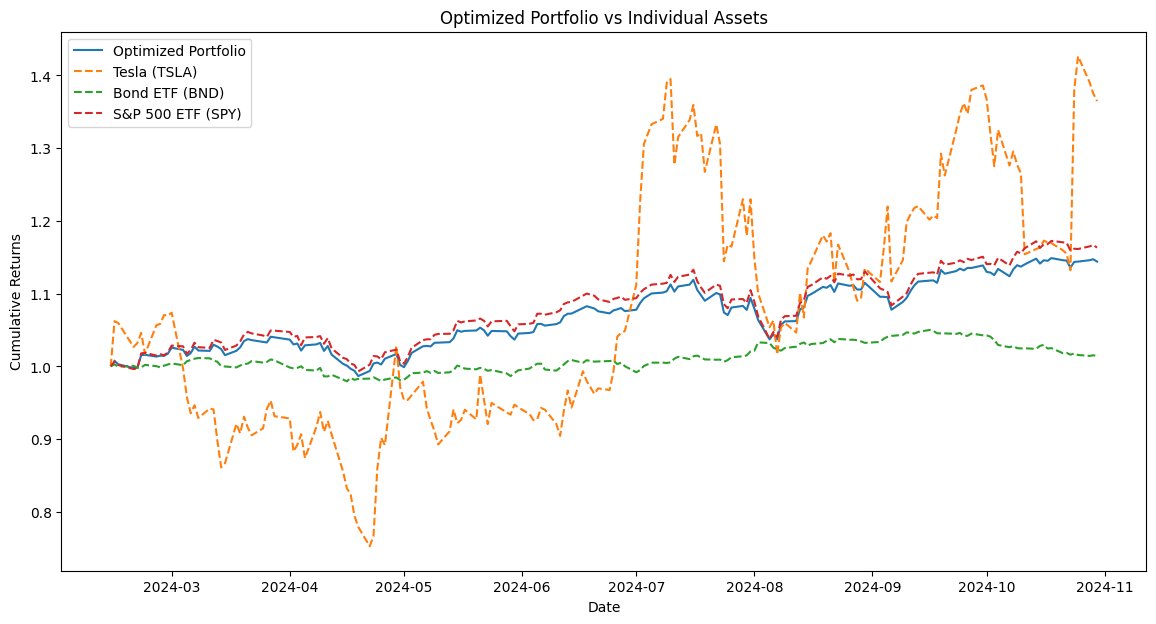

In [21]:
plt.figure(figsize=(14, 7))
cumulative_returns = (daily_returns + 1).cumprod() * optimal_weights
cumulative_portfolio = cumulative_returns.sum(axis=1)

plt.plot(cumulative_portfolio.index, cumulative_portfolio, label="Optimized Portfolio")
plt.plot(df.index, df['TSLA'] / df['TSLA'].iloc[0], label="Tesla (TSLA)", linestyle="--")
plt.plot(df.index, df['BND'] / df['BND'].iloc[0], label="Bond ETF (BND)", linestyle="--")
plt.plot(df.index, df['SPY'] / df['SPY'].iloc[0], label="S&P 500 ETF (SPY)", linestyle="--")

plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.title("Optimized Portfolio vs Individual Assets")
plt.legend()
plt.show()

### **Interpretation**

### Step 8: Print Portfolio Metrics

In [22]:
print("Optimal Portfolio Weights:", dict(zip(df.columns, optimal_weights)))
print("Expected Annual Return:", round(opt_return, 4))
print("Expected Annual Volatility:", round(opt_volatility, 4))
print("Sharpe Ratio:", round(opt_sharpe, 4))
print("Tesla VaR (95% CI):", round(VaR_tsla, 4))

Optimal Portfolio Weights: {'TSLA': np.float64(0.02245656104382966), 'BND': np.float64(0.15985681272219124), 'SPY': np.float64(0.8176866262339791)}
Expected Annual Return: 0.1981
Expected Annual Volatility: 0.1106
Sharpe Ratio: 1.7918
Tesla VaR (95% CI): 0.0005
